In [97]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
import factors
import observation_models
import state_models
from ssm_em import StateSpaceEM
from pykalman import KalmanFilter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
T = 1000
trange = numpy.arange(T)
Dx = 3
Dz = 2
X = numpy.empty((T,Dx))
X[:,0] = numpy.sin(trange / 20)
X[:,1] = numpy.sin(trange / 10)
X[:,2] = numpy.sin(trange / 5)
noise_x = .2
noise_z = .1
X += noise_x * numpy.random.randn(*X.shape)

In [99]:
transition_covariance = .01 * numpy.eye(Dz)
kf = KalmanFilter(n_dim_obs=Dx,n_dim_state=Dz, em_vars=['transition_covariance'], 
                  transition_covariance=transition_covariance,
                  )

In [108]:
class CustomStateModel(state_models.LinearStateModel):
    
    def update_hyperparameters(self, smoothing_density: 'GaussianDensity', 
                               two_step_smoothing_density: 'GaussianDensity', **kwargs):
        """ The hyperparameters are updated here, where the the densities p(z_t|x_{1:T}) and 
        p(z_{t+1}, z_t|x_{1:T}) are provided (the latter for the cross-terms.)
        
        :param smoothing_density: GaussianDensity
            The smoothing density  p(z_t|x_{1:T}).
        :param two_step_smoothing_density: Gaussian Density
            The two point smoothing density  p(z_{t+1}, z_t|x_{1:T}).
        """
        #self.update_A(smoothing_density, two_step_smoothing_density)
        #self.update_b(smoothing_density)
        self.update_Qz(smoothing_density, two_step_smoothing_density)
        self.update_state_density()
        
        
    def update_Qz(self, smoothing_density: 'GaussianDensity', two_step_smoothing_density: 'GaussianDensity'):
        """ The transition covariance is updated here, where the the densities p(z_t|x_{1:T}) and 
        p(z_{t+1}, z_t|x_{1:T}) are provided (the latter for the cross-terms.)
        
        :param smoothing_density: GaussianDensity
            The smoothing density  p(z_t|x_{1:T}).
        :param two_step_smoothing_density: Gaussian Density
            The two point smoothing density  p(z_{t+1}, z_t|x_{1:T}).
        """
        T = two_step_smoothing_density.R
        #Ezz_two_step = two_step_smoothing_density.integrate('xx')
        #Ezz = Ezz_two_step[:,self.Dz:,self.Dz:]
        #Ezz_cross = Ezz_two_step[:,:self.Dz,self.Dz:]
        #AEzz_cross = numpy.sum(numpy.einsum('ab,cbd->cad', self.A, Ezz_cross), axis=0)
        #Ez_b = smoothing_density.mu[:,None] * self.b[None,:,None]
        #AEz_b = numpy.sum(numpy.einsum('ab,cbd->cad', self.A, Ez_b[:-1]), axis=0)
        #Az_b2 = numpy.sum(smoothing_density.integrate('Ax_aBx_b_outer', A_mat=self.A, a_vec=self.b, 
        #                                              B_mat=self.A, b_vec=self.b)[:-1],axis=0)
        #mu_b = numpy.sum(Ez_b[1:], axis=0)
        #AEzzA = numpy.einsum('ab,bc->ac', numpy.einsum('ab,bc->ac', self.A, numpy.sum(Ezz[:-1], axis=0)), self.A.T)
        #print(AEzzA, numpy.sum(Ezz[:-1], axis=0).shape)
        
        #Qz = (numpy.sum(Ezz[1:], axis=0) + Az_b2 - mu_b - mu_b.T - AEzz_cross - AEzz_cross.T) / T# +  - mu_b - mu_b.T - AEzz_cross - AEzz_cross.T) / T
        A_tilde = numpy.eye(2*self.Dz, self.Dz)
        A_tilde[self.Dz:] = -self.A
        print(A_tilde.shape)
        b_tilde = -self.b
        Qz = numpy.mean(two_step_smoothing_density.integrate('Ax_aBx_b_outer', A_mat=A_tilde.T, a_vec=b_tilde, B_mat=A_tilde.T, b_vec=b_tilde), axis=0)
        return Qz
        #eigvals, eigvecs = numpy.linalg.eig(self.Qz)
        #self.Qz += 1e-4 * numpy.eye(self.Dz) 
        
    def update_A(self, smoothing_density: 'GaussianDensity', 
                 two_step_smoothing_density: 'GaussianDensity'):
        """ The transition matrix is updated here, where the the densities
        p(z_{t+1}, z_t|x_{1:T}) is provided.
        
        :param smoothing_density: GaussianDensity
            The smoothing density  p(z_t|x_{1:T}).
        :param two_step_smoothing_density: Gaussian Density
            The two point smoothing density  p(z_{t+1}, z_t|x_{1:T}).
        """
        #Ezz = smoothing_density.integrate('xx')
        mu_b = smoothing_density.mu[:-1,None] * self.b[None,:,None]
        Ezz_two_step = two_step_smoothing_density.integrate('xx')
        Ezz = Ezz_two_step[:,self.Dz:,self.Dz:]
        Ezz_cross = Ezz_two_step[:,self.Dz:,:self.Dz]
        A = numpy.mean(Ezz, axis=0) #+ 1e-2 * numpy.eye(self.Dz)
        return numpy.linalg.solve(A, numpy.mean(Ezz_cross -  mu_b, axis=0)).T
    
    def update_b(self, smoothing_density: 'GaussianDensity'):
        """ The transition offset is updated here, where the the densities p(z_t|x_{1:T}) is provided.
        
        :param smoothing_density: GaussianDensity
            The smoothing density  p(z_t|x_{1:T}).
        """
        return numpy.mean(smoothing_density.mu[1:] - numpy.dot(self.A, smoothing_density.mu[:-1].T).T, axis=0)
        
        
class CustomObservationModel(observation_models.LinearObservationModel):
    
    def update_hyperparameters(self, smoothing_density: 'GaussianDensity', X: numpy.ndarray, **kwargs):
        """ This procedure updates the hyperparameters of the observation model.
        
        :param smoothing_density: GaussianDensity
            The smoothing density over the latent space.
        :param X: numpy.ndarray [T, Dx]
            The observations.
        """  
        #self.update_C(smoothing_density, X)
        #self.update_d(smoothing_density, X)
        #self.update_Qx(smoothing_density, X)
        self.update_emission_density()
    
    def update_Qx(self, smoothing_density: 'GaussianDensity', X: numpy.ndarray):
        """ This procedure updates the covariance of the observation model.
        
        :param smoothing_density: GaussianDensity
            The smoothing density over the latent space.
        :param X: numpy.ndarray [T, Dx]
            The observations.
        """  
        T = X.shape[0]
        A = -self.C
        a_t = X - self.d[None]
        Exx = numpy.zeros((self.Dx, self.Dx))
        for t in range(1, T+1):
            cur_smooth_density = smoothing_density.slice([t])
            Exx += cur_smooth_density.integrate('Ax_aBx_b_outer', A_mat=A, 
                                                a_vec=a_t[t-1], B_mat=A, 
                                                b_vec=a_t[t-1])[0]
        return Exx / T
    
    def update_C(self, smoothing_density: 'GaussianDensity', X: numpy.ndarray):
        """ This procedure updates the transition matrix of the observation model.
        
        :param smoothing_density: GaussianDensity
            The smoothing density over the latent space.
        :param X: numpy.ndarray [T, Dx]
            The observations.
        """  
        Ezz = numpy.sum(smoothing_density.integrate('xx')[1:], axis=0)
        Ez = smoothing_density.integrate('x')[1:]
        zx = numpy.sum(Ez[:,:,None] * (X[:,None] - self.d[None,None]), axis=0)
        return numpy.linalg.solve(Ezz, zx).T
    
    def update_d(self, smoothing_density: 'GaussianDensity', X: numpy.ndarray):
        """ This procedure updates the transition offset of the observation model.
        
        :param smoothing_density: GaussianDensity
            The smoothing density over the latent space.
        :param X: numpy.ndarray [T, Dx]
            The observations.
        """ 
        return numpy.mean(X - numpy.dot(smoothing_density.mu[1:], self.C.T), axis=0)

In [109]:
sm = CustomStateModel(Dz, noise_z=numpy.sqrt(.01))
#sm.Qz = numpy.eye(Dz)
sm.A = numpy.eye(Dz)
sm.b = numpy.zeros((Dz,))
sm.update_state_density()
om = CustomObservationModel(Dx, Dz, noise_x=1)
om.Qx = numpy.eye(Dx)
om.C = numpy.eye(Dx, Dz)
om.d = numpy.zeros((Dx,))
om.update_emission_density()
#om.pca_init(X)

In [110]:
ssm_em_lin = StateSpaceEM(X, observation_model=om, state_model=sm)

In [111]:
ssm_em_lin.estep()

In [112]:
ssm_em_lin.om.update_d(ssm_em_lin.smoothing_density, X)

array([ 0.00034607,  0.00042751, -0.00694519])

In [116]:
standard._em_observation_offset(self.observation_matrices, smoothed_state_means,
                           Z)

array([ 0.00034923,  0.00043141, -0.00694519])

In [113]:
mu_kf, cov_kf = kf.smooth(X)

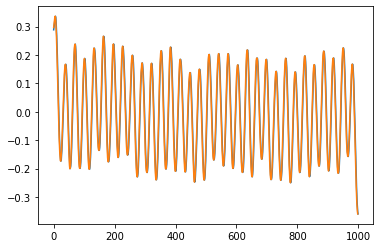

In [9]:
pyplot.plot(mu_kf[:,2])
pyplot.plot(ssm_em_lin.twostep_smoothing_density.mu[1:,2])

In [76]:
ssm_em_lin.twostep_smoothing_density.mu[:,3:] - ssm_em_lin.smoothing_density.mu[:-1]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

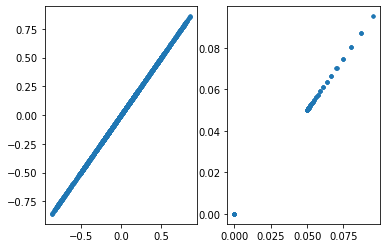

In [77]:
pyplot.subplot(121)
pyplot.plot(mu_kf.flatten(), ssm_em_lin.smoothing_density.mu[1:].flatten(), '.')
pyplot.subplot(122)
pyplot.plot(cov_kf.flatten(), ssm_em_lin.smoothing_density.Sigma[1:].flatten(), '.')

In [10]:
from pykalman import standard

In [115]:
self = kf
(self.transition_matrices, self.transition_offsets,
         self.transition_covariance, self.observation_matrices,
         self.observation_offsets, self.observation_covariance,
         self.initial_state_mean, self.initial_state_covariance) = (
            self._initialize_parameters()
        )
Z = self._parse_observations(X)
(predicted_state_means, predicted_state_covariances,
             kalman_gains, filtered_state_means,
             filtered_state_covariances) = (
                standard._filter(
                    self.transition_matrices, self.observation_matrices,
                    self.transition_covariance, self.observation_covariance,
                    self.transition_offsets, self.observation_offsets,
                    self.initial_state_mean, self.initial_state_covariance,
                    Z
                )
            )
(smoothed_state_means, smoothed_state_covariances,
             kalman_smoothing_gains) = (
                standard._smooth(
                    self.transition_matrices, filtered_state_means,
                    filtered_state_covariances, predicted_state_means,
                    predicted_state_covariances
                )
            )

sigma_pair_smooth = standard._smooth_pair(
                smoothed_state_covariances,
                kalman_smoothing_gains
            )

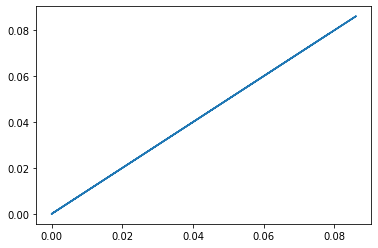

In [12]:
pyplot.plot(sigma_pair_smooth[1:].flatten(), ssm_em_lin.twostep_smoothing_density.Sigma[1:,3:,:3].flatten())

In [13]:
import numpy as np

def _last_dims(X, t, ndims=2):
    """Extract the final dimensions of `X`
    Extract the final `ndim` dimensions at index `t` if `X` has >= `ndim` + 1
    dimensions, otherwise return `X`.
    Parameters
    ----------
    X : array with at least dimension `ndims`
    t : int
        index to use for the `ndims` + 1th dimension
    ndims : int, optional
        number of dimensions in the array desired
    Returns
    -------
    Y : array with dimension `ndims`
        the final `ndims` dimensions indexed by `t`
    """
    X = np.asarray(X)
    if len(X.shape) == ndims + 1:
        return X[t]
    elif len(X.shape) == ndims:
        return X
    else:
        raise ValueError(("X only has %d dimensions when %d" +
                " or more are required") % (len(X.shape), ndims))

def _em_transition_covariance(transition_matrices, transition_offsets,
                              smoothed_state_means, smoothed_state_covariances,
                              pairwise_covariances):
    r"""Apply the EM algorithm to parameter `transition_covariance`
    Maximize expected log likelihood of observations with respect to the
    transition covariance matrix `transition_covariance`.
    .. math::
        Q &= \frac{1}{T-1} \sum_{t=0}^{T-2}
                (\mathbb{E}[x_{t+1}] - A_t \mathbb{E}[x_t] - b_t)
                    (\mathbb{E}[x_{t+1}] - A_t \mathbb{E}[x_t] - b_t)^T
                + A_t Var(x_t) A_t^T + Var(x_{t+1})
                - Cov(x_{t+1}, x_t) A_t^T - A_t Cov(x_t, x_{t+1})
    """
    n_timesteps, n_dim_state, _ = smoothed_state_covariances.shape
    res = np.zeros((n_dim_state, n_dim_state))
    for t in range(n_timesteps - 1):
        transition_matrix = _last_dims(transition_matrices, t)
        transition_offset = _last_dims(transition_offsets, t, ndims=1)
        err = (
            smoothed_state_means[t + 1]
            - np.dot(transition_matrix, smoothed_state_means[t])
            - transition_offset
        )
        Vt1t_A = (
            np.dot(pairwise_covariances[t + 1],
                   transition_matrix.T)
        )
        res += (
            np.outer(err, err)
            + np.dot(transition_matrix,
                     np.dot(smoothed_state_covariances[t],
                            transition_matrix.T))
            + smoothed_state_covariances[t + 1]
            - Vt1t_A - Vt1t_A.T
        )

    return (1.0 / (n_timesteps - 1)) * res

_em_transition_covariance(self.transition_matrices, self.transition_offsets,
                                  smoothed_state_means, smoothed_state_covariances,
                                  sigma_pair_smooth)

array([[ 1.02734742e-02, -2.30536431e-05, -8.48758398e-06],
       [-2.30536431e-05,  1.07589367e-02,  3.19614321e-06],
       [-8.48758398e-06,  3.19614321e-06,  1.03089959e-02]])

In [14]:
ssm_em_lin.sm.update_Qz(ssm_em_lin.smoothing_density, ssm_em_lin.twostep_smoothing_density)

(6, 3)


array([[ 1.02731182e-02, -2.30213958e-05, -8.47004693e-06],
       [-2.30213958e-05,  1.07581073e-02,  3.20741785e-06],
       [-8.47004693e-06,  3.20741785e-06,  1.03086122e-02]])

In [15]:
standard._em_transition_matrix(
            self.transition_offsets, smoothed_state_means,
            smoothed_state_covariances, sigma_pair_smooth 
        )

array([[9.86717180e-01, 2.32697760e-03, 1.01547456e-03],
       [6.58771731e-04, 9.71808392e-01, 4.65199591e-03],
       [1.11646568e-03, 7.95400672e-04, 9.28871392e-01]])

In [16]:
ssm_em_lin.sm.update_A(ssm_em_lin.smoothing_density, ssm_em_lin.twostep_smoothing_density)

array([[9.86701936e-01, 2.34170333e-03, 1.04118003e-03],
       [6.71674349e-04, 9.71807076e-01, 4.70432919e-03],
       [1.13505938e-03, 8.45650417e-04, 9.28924874e-01]])

In [17]:
def _em_transition_offset(transition_matrices, smoothed_state_means):
    r"""Apply the EM algorithm to parameter `transition_offset`
    Maximize expected log likelihood of observations with respect to the
    state transition offset `transition_offset`.
    .. math::
        b = \frac{1}{T-1} \sum_{t=1}^{T-1}
                \mathbb{E}[x_t] - A_{t-1} \mathbb{E}[x_{t-1}]
    """
    n_timesteps, n_dim_state = smoothed_state_means.shape
    transition_offset = np.zeros(n_dim_state)
    for t in range(1, n_timesteps):
        transition_matrix = _last_dims(transition_matrices, t - 1)
        transition_offset += (
            smoothed_state_means[t]
            - np.dot(transition_matrix, smoothed_state_means[t - 1])
        )
    if n_timesteps > 1:
        return (1.0 / (n_timesteps - 1)) * transition_offset
    else:
        return np.zeros(n_dim_state)
    
standard._em_transition_offset(
            self.transition_matrices, smoothed_state_means 
        )

array([-0.00098383, -0.00117498, -0.00064877])

In [22]:
ssm_em_lin.sm.update_b(ssm_em_lin.smoothing_density)

array([-0.00097966, -0.00116983, -0.00064551])

In [26]:
def _em_observation_covariance(observations, observation_offsets,
                              transition_matrices, smoothed_state_means,
                              smoothed_state_covariances):
    r"""Apply the EM algorithm to parameter `observation_covariance`
    Maximize expected log likelihood of observations with respect to the
    observation covariance matrix `observation_covariance`.
    .. math::
        R &= \frac{1}{T} \sum_{t=0}^{T-1}
                [z_t - C_t \mathbb{E}[x_t] - b_t]
                    [z_t - C_t \mathbb{E}[x_t] - b_t]^T
                + C_t Var(x_t) C_t^T
    """
    _, n_dim_state = smoothed_state_means.shape
    n_timesteps, n_dim_obs = observations.shape
    res = np.zeros((n_dim_obs, n_dim_obs))
    n_obs = 0
    for t in range(n_timesteps):
        if not np.any(np.ma.getmask(observations[t])):
            transition_matrix = _last_dims(transition_matrices, t)
            transition_offset = _last_dims(observation_offsets, t, ndims=1)
            err = (
                observations[t]
                - np.dot(transition_matrix, smoothed_state_means[t])
                - transition_offset
            )
            res += (
                np.outer(err, err)
                + np.dot(transition_matrix,
                         np.dot(smoothed_state_covariances[t],
                                transition_matrix.T))
            )
            n_obs += 1
    if n_obs > 0:
        return (1.0 / n_obs) * res
    else:
        return res
    
standard._em_observation_covariance(
            Z, self.observation_offsets,
            self.observation_matrices, smoothed_state_means,
            smoothed_state_covariances
        )

array([[ 1.06600329e-01,  2.00701415e-05, -1.04048450e-03],
       [ 2.00701415e-05,  2.11581623e-01, -1.31712314e-03],
       [-1.04048450e-03, -1.31712314e-03,  4.01369515e-01]])

In [32]:
ssm_em_lin.om.update_Qx(ssm_em_lin.smoothing_density, X)

array([[ 1.06601323e-01,  2.04032979e-05, -1.04056493e-03],
       [ 2.04032979e-05,  2.11581964e-01, -1.31754370e-03],
       [-1.04056493e-03, -1.31754370e-03,  4.01369405e-01]])

In [40]:
standard._em_observation_matrix(
            Z, self.observation_offsets,
            smoothed_state_means, smoothed_state_covariances
        )

array([[ 1.07070891, -0.01486059, -0.01409952],
       [-0.01561041,  1.40538839, -0.0146886 ],
       [-0.00698757, -0.00598308,  1.41596565]])

In [41]:
ssm_em_lin.om.update_C(ssm_em_lin.smoothing_density, X)

array([[ 1.070703  , -0.01487085, -0.01411257],
       [-0.01561801,  1.40536851, -0.01470954],
       [-0.00699161, -0.00599141,  1.41594795]])

In [56]:
standard._em_observation_offset(self.observation_matrices, smoothed_state_means,
                           Z)

array([-0.00098383, -0.00117498, -0.00064877])

In [57]:
ssm_em_lin.om.update_d(ssm_em_lin.smoothing_density, X)

array([0.0003491 , 0.00043463, 0.00028611])

In [85]:
from pykalman import KalmanFilter

In [18]:
transition_covariance = .01 * numpy.eye(Dz)
kf = KalmanFilter(n_dim_obs=Dx,n_dim_state=Dz, em_vars=['transition_matrices', 'transition_offset', 'transition_covariance'], 
                  transition_covariance=transition_covariance,
                  )

In [19]:
kf.em(X, n_iter=1)

In [20]:
kf.transition_covariance

array([[ 1.02428792e-02, -2.79557533e-05,  1.21144294e-05],
       [-2.79557533e-05,  1.05750286e-02,  1.33580406e-06],
       [ 1.21144294e-05,  1.33580406e-06,  9.96972845e-03]])

In [23]:
ssm_em_lin.sm.A

array([[ 1.00049979,  0.01266418, -0.00384717],
       [ 0.00238279,  1.00223197,  0.00346555],
       [ 0.00167046,  0.00386879,  0.97659196]])

In [24]:
kf.transition_matrices

array([[9.87284293e-01, 1.34410567e-03, 1.15251589e-04],
       [1.16920140e-03, 9.71463050e-01, 8.17829668e-04],
       [2.28893524e-03, 1.90550277e-03, 9.29813750e-01]])